# YOLO V2 with TensorFlow 2.0

**TO DO**
- oversampling of parasitized labels
- recut images so that we can use all labels in the training

In [59]:
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import imgaug as ia
from imgaug import augmenters as iaa
import pickle
from sklearn.model_selection import train_test_split
import bbox_visualizer as bbv

In [60]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [61]:
# Parameters

LABELS           = ('Uninfected', 'Parasitized', 'White_Blood_Cell')
IMAGE_H, IMAGE_W = 256, 256
GRID_H,  GRID_W  = 8, 8 # GRID size = IMAGE size / 32
BOX              = 5
CLASS            = len(LABELS)
SCORE_THRESHOLD  = 0.5
IOU_THRESHOLD    = 0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE   = 16
EPOCHS           = 200

LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

max_annot        = 0

In [62]:
# Train and validation directory

train_image_folder = '../data/train/image/'
train_annot_folder = '../data/train/annotation/'
val_image_folder = '../data/val/image/'
val_annot_folder = '../data/val/annotation/'

# 1. Define YOLO model

In [63]:
# Custom Keras layer

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [64]:
# Yolo model (thanks to https://github.com/experiencor/keras-yolo2)

input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, BOX, 4 + 1 + CLASS))(x)

model = keras.models.Model(input_image, output)

In [65]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_88 (LeakyReLU)      (None, 256, 256, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

# 2. Load YOLO pretrained weigts

In [66]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [67]:
weight_reader = WeightReader('../data/weights/yolov2.weights')

In [68]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    conv_layer.trainable = True
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        norm_layer.trainable = True
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [69]:
layer   = model.layers[-2] # last convolutional layer
layer.trainable = True


weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [70]:
new_bias

array([ 0.0268144 ,  0.00860237, -0.01090736,  0.02835374, -0.00845363,
       -0.00080028,  0.00837959, -0.01950321, -0.01722015,  0.00302051,
        0.01212504,  0.00061834, -0.00147527, -0.0236212 ,  0.02778593,
        0.00770602,  0.01448044,  0.007558  ,  0.00589132,  0.0065397 ,
       -0.00745826, -0.02533131, -0.00617864,  0.02118863, -0.01295031,
       -0.01813726, -0.01410316,  0.00317566, -0.0135647 ,  0.01131774,
        0.02598277,  0.00159931, -0.01680727,  0.01682428,  0.00683641,
        0.01687816,  0.00934354,  0.01350207,  0.02465599, -0.01959683])

# 3. Data generator

In [71]:
def parse_annotation(ann_dir, img_dir, labels):
    '''
    Parse XML files in PASCAL VOC format.
    
    Parameters
    ----------
    - ann_dir : annotations files directory
    - img_dir : images files directory
    - labels : labels list
    
    Returns
    -------
    - imgs_name : numpy array of images files path (shape : images count, 1)
    - true_boxes : numpy array of annotations for each image (shape : image count, max annotation count, 5)
        annotation format : xmin, ymin, xmax, ymax, class
        xmin, ymin, xmax, ymax : image unit (pixel)
        class = label index
    '''
    
    max_annot = 0
    imgs_name = []
    annots = []
    
    # Parse file
    for ann in sorted(os.listdir(ann_dir)):
        annot_count = 0
        boxes = []
        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter(): 
            if 'filename' in elem.tag:
                imgs_name.append(img_dir + elem.text)
            if 'width' in elem.tag:
                w = int(elem.text)
            if 'height' in elem.tag:
                h = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:                  
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        box[4] = labels.index(attr.text) + 1 # 0:label for no bounding box
                    if 'bndbox' in attr.tag:
                        annot_count += 1
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                box[0] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                box[1] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                box[2] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                box[3] = int(round(float(dim.text)))
                boxes.append(np.asarray(box))
        
        if w != IMAGE_W or h != IMAGE_H :
            print('Image size error')
            break
            
        annots.append(np.asarray(boxes))
        

        if annot_count > max_annot:
            max_annot = annot_count
           
    # Rectify annotations boxes : len -> max_annot
    imgs_name = np.array(imgs_name)  
    true_boxes = np.zeros((imgs_name.shape[0], max_annot, 5))
    for idx, boxes in enumerate(annots):
        true_boxes[idx, :boxes.shape[0], :5] = boxes
        
    return imgs_name, true_boxes

## 3.1. Dataset

In [72]:
def parse_function(img_obj, true_boxes):
    x_img_string = tf.io.read_file(img_obj)
    x_img = tf.image.decode_png(x_img_string, channels=3) # dtype=tf.uint8
    x_img = tf.image.convert_image_dtype(x_img, tf.float32) # pixel value /255, dtype=tf.float32, channels : RGB
    return x_img, true_boxes

def get_dataset(imgs_name, bbox, batch_size):
    '''
    Create a YOLO dataset
    
    Parameters
    ----------
    - ann_dir : annotations files directory
    - img_dir : images files directory
    - labels : labels list
    - batch_size : int
    
    Returns
    -------
    - YOLO dataset : generate batch
        batch : tupple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
    Note : image pixel values = pixels value / 255. channels : RGB
    '''
    
    # imgs_name, bbox = parse_annotation(ann_dir, img_dir, LABELS)

    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, bbox))    
    dataset = dataset.shuffle(len(imgs_name))
    dataset = dataset.repeat()
    dataset = dataset.map(parse_function, num_parallel_calls=6)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    print('-------------------')
    print('Dataset:')
    print('Images count: {}'.format(len(imgs_name)))
    print('Step per epoch: {}'.format(len(imgs_name) // batch_size))
    print('Images per epoch: {}'.format(batch_size * (len(imgs_name) // batch_size)))
    return dataset

In [73]:
with open('../data/pickled/imgs_name.pkl', 'rb') as handle:
    imgs_name = pickle.load(handle)
with open('../data/pickled/true_boxes.pkl', 'rb') as handle:
    true_boxes = pickle.load(handle)
with open('../data/pickled/dict_bbxs.pkl', 'rb') as handle:
    dict_bbxs = pickle.load(handle)

In [74]:
len(imgs_name)

15381

In [75]:
len(true_boxes)

15381

## Risky operation to define all blood cells as cells

In [76]:
# category cells

cells = []
for img_set in true_boxes:
    for label in img_set:
        label[4] = 0
        cells.append(label)
            
print('cells: ', len(cells))       
print('true_boxes: ', len(true_boxes))        

cells:  538335
true_boxes:  15381


In [77]:
bbox = true_boxes
imgs_name_train, imgs_name_test, bbox_train, bbox_test = train_test_split(imgs_name, bbox, test_size = 0.2)
train_dataset = None
train_dataset= get_dataset(imgs_name_train, bbox_train, TRAIN_BATCH_SIZE)

val_dataset = None
val_dataset= get_dataset(imgs_name_test, bbox_test, VAL_BATCH_SIZE)

-------------------
Dataset:
Images count: 12304
Step per epoch: 769
Images per epoch: 12304
-------------------
Dataset:
Images count: 3077
Step per epoch: 192
Images per epoch: 3072


In [78]:
# Test dataset

def test_dataset(dataset):
    for batch in dataset:
        img = batch[0][0]
        label = batch[1][0]
        plt.figure(figsize=(2,2))
        f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
        ax1.imshow(img)
        ax1.set_title('Input image. Shape : {}'.format(img.shape))
        for i in range(label.shape[0]):
            box = label[i,:]
            box = box.numpy()
            x = box[0]
            y = box[1]
            w = box[2] - box[0]
            h = box[3] - box[1]
            if box[4] == 1:
                color = (1, 0, 0)
            elif box[4] == 2:
                color = (0, 0, 1)
            else:
                color = (0, 1, 0)
            rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor=color,facecolor='none')
            ax1.add_patch(rect)
        break

<Figure size 144x144 with 0 Axes>

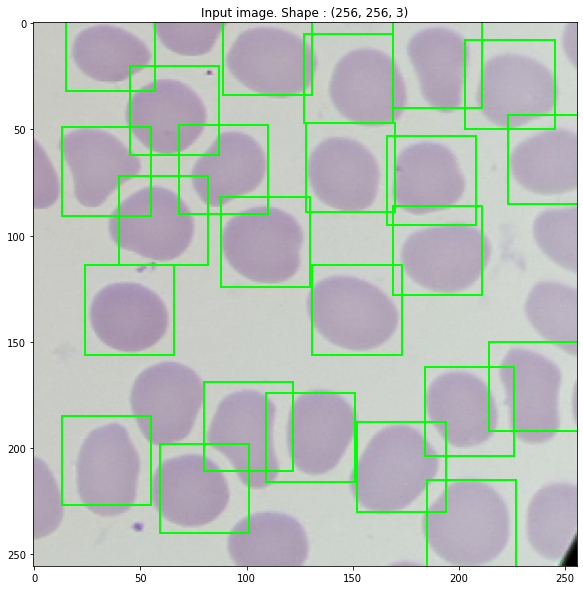

In [79]:
test_dataset(train_dataset)

## Oversampling 
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversampling

It seems, that we are loosing quite a few labels through the downscaling/ cutting of the images into smaller tiles as we exclude labels that are not 100% visible in the cut image.

In [80]:
dataset = tf.data.Dataset.from_tensor_slices((imgs_name, bbox))  
for features, label in dataset.take(1):
    print(label.numpy().mean())

35.2


In [81]:
for features, label in dataset.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 b'../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_512_256_256_0.png'

Label:  [[188.  41. 224.  80.   0.]
 [173. 101. 210. 144.   0.]
 [137.  85. 174. 122.   0.]
 [111. 111. 144. 146.   0.]
 [ 70. 104. 100. 132.   0.]
 [197. 153. 238. 191.   0.]
 [ 28. 127.  67. 156.   0.]
 [111. 151. 151. 191.   0.]
 [ 21. 160.  59. 196.   0.]
 [ 75. 195. 116. 233.   0.]
 [146. 189. 181. 231.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  

In [82]:
uninfected = []
parasitized = []
wbc = []
for features, labels in dataset:
    for label in labels.numpy():
        if label[4] == 0 and label[:4].all() != 0:
            uninfected.append(label)
        if label[4] == 1:
            parasitized.append(label)        
        if label[4] == 2:
            wbc.append(label)
            
print('uninfected: ', len(uninfected))
print('parasitized: ', len(parasitized))
print('wbc: ', len(wbc))

uninfected:  191679
parasitized:  0
wbc:  0


## 3.2. Data augmentation

In [83]:
def augmentation_generator(yolo_dataset):
    '''
    Augmented batch generator from a yolo dataset

    Parameters
    ----------
    - YOLO dataset
    
    Returns
    -------
    - augmented batch : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch : tupple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
    '''
    for batch in yolo_dataset:
        # conversion tensor->numpy
        img = batch[0].numpy()
        boxes = batch[1].numpy()
        # conversion bbox numpy->ia object
        ia_boxes = []
        for i in range(img.shape[0]):
            ia_bbs = [ia.BoundingBox(x1=bb[0],
                                       y1=bb[1],
                                       x2=bb[2],
                                       y2=bb[3]) for bb in boxes[i]
                      if (bb[0] + bb[1] +bb[2] + bb[3] > 0)]
            ia_boxes.append(ia.BoundingBoxesOnImage(ia_bbs, shape=(IMAGE_W, IMAGE_H)))
        # data augmentation
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            #iaa.Multiply((0.4, 1.6)), # change brightness
            #iaa.ContrastNormalization((0.5, 1.5)),
            #iaa.Affine(translate_px={"x": (-100,100), "y": (-100,100)}, scale=(0.7, 1.30))
            ])
        #seq = iaa.Sequential([])
        seq_det = seq.to_deterministic()
        img_aug = seq_det.augment_images(img)
        img_aug = np.clip(img_aug, 0, 1)
        boxes_aug = seq_det.augment_bounding_boxes(ia_boxes)
        # conversion ia object -> bbox numpy
        for i in range(img.shape[0]):
            boxes_aug[i] = boxes_aug[i].remove_out_of_image().clip_out_of_image()
            for j, bb in enumerate(boxes_aug[i].bounding_boxes):
                boxes[i,j,0] = bb.x1
                boxes[i,j,1] = bb.y1
                boxes[i,j,2] = bb.x2
                boxes[i,j,3] = bb.y2
        # conversion numpy->tensor
        batch = (tf.convert_to_tensor(img_aug), tf.convert_to_tensor(boxes))
        #batch = (img_aug, boxes)
        yield batch

In [84]:
aug_train_dataset = augmentation_generator(train_dataset)

<Figure size 144x144 with 0 Axes>

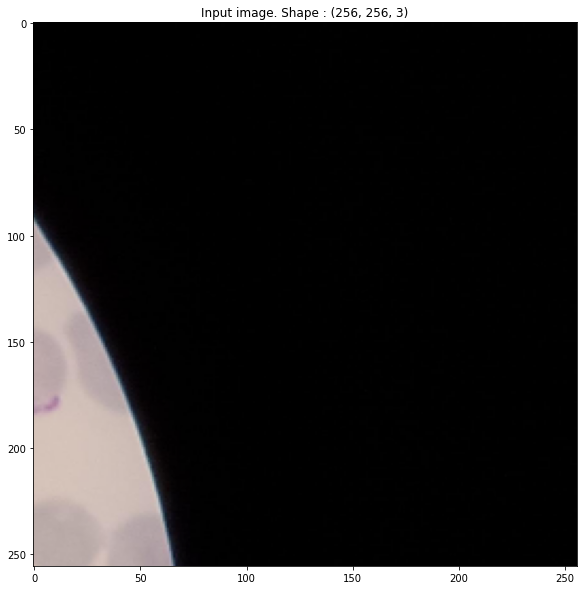

In [85]:
test_dataset(aug_train_dataset)

## 3.3. Process data to YOLO prediction format

In [86]:
def process_true_boxes(true_boxes, anchors, image_width, image_height):
    '''
    Build image ground truth in YOLO format from image true_boxes and anchors.
    
    Parameters
    ----------
    - true_boxes : tensor, shape (max_annot, 5), format : x1 y1 x2 y2 c, coords unit : image pixel
    - anchors : list [anchor_1_width, anchor_1_height, anchor_2_width, anchor_2_height...]
        anchors coords unit : grid cell
    - image_width, image_height : int (pixels)
    
    Returns
    -------
    - detector_mask : array, shape (GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : array, shape (GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    -true_boxes_grid : array, same shape than true_boxes (max_annot, 5),
        format : x, y, w, h, c, coords unit : grid cell
        
    Note:
    -----
    Bounding box in YOLO Format : x, y, w, h, c
    x, y : center of bounding box, unit : grid cell
    w, h : width and height of bounding box, unit : grid cell
    c : label index
    ''' 
    
    scale = IMAGE_W / GRID_W # scale = 32
    
    anchors_count = len(anchors) // 2
    anchors = np.array(anchors)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    detector_mask = np.zeros((GRID_W, GRID_H, anchors_count, 1))
    matching_true_boxes = np.zeros((GRID_W, GRID_H, anchors_count, 5))
    
    # convert true_boxes numpy array -> tensor
    true_boxes = true_boxes.numpy()
    
    true_boxes_grid = np.zeros(true_boxes.shape)
    
    # convert bounding box coords and localize bounding box
    for i, box in enumerate(true_boxes):
        # convert box coords to x, y, w, h and convert to grids coord
        w = (box[2] - box[0]) / scale
        h = (box[3] - box[1]) / scale    
        x = ((box[0] + box[2]) / 2) / scale
        y = ((box[1] + box[3]) / 2) / scale
        true_boxes_grid[i,...] = np.array([x, y, w, h, box[4]])
        if w * h > 0: # box exists
            # calculate iou between box and each anchors and find best anchors
            best_iou = 0
            best_anchor = 0
            for i in range(anchors_count): 
                # iou (anchor and box are shifted to 0,0)
                intersect = np.minimum(w, anchors[i,0]) * np.minimum(h, anchors[i,1])
                union = (anchors[i,0] * anchors[i,1]) + (w * h) - intersect
                iou = intersect / union
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = i
            # localize box in detector_mask and matching true_boxes
            if best_iou > 0:
                x_coord = np.floor(x).astype('int')
                y_coord = np.floor(y).astype('int')
                detector_mask[y_coord, x_coord, best_anchor] = 1
                yolo_box = np.array([x, y, w, h, box[4]])
                matching_true_boxes[y_coord, x_coord, best_anchor] = yolo_box
    return matching_true_boxes, detector_mask, true_boxes_grid

In [87]:
def ground_truth_generator(dataset):
    '''
    Ground truth batch generator from a yolo dataset, ready to compare with YOLO prediction in loss function.

    Parameters
    ----------
    - YOLO dataset. Generate batch:
        batch : tupple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
        
    Returns
    -------
    - imgs : images to predict. tensor (shape : batch_size, IMAGE_H, IMAGE_W, 3)
    - detector_mask : tensor, shape (batch, size, GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - class_one_hot : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, class_count)
        One hot representation of bounding box label
    - true_boxes_grid : annotations : tensor (shape : batch_size, max annot, 5)
        true_boxes format : x, y, w, h, c, coords unit : grid cell
    '''
    for batch in dataset:
        # imgs
        imgs = batch[0]
        
        # true boxes
        true_boxes = batch[1]
        
        # matching_true_boxes and detector_mask
        batch_matching_true_boxes = []
        batch_detector_mask = []
        batch_true_boxes_grid = []
        
        for i in range(true_boxes.shape[0]):     
            one_matching_true_boxes, one_detector_mask, true_boxes_grid = process_true_boxes(true_boxes[i],
                                                                                           ANCHORS,
                                                                                           IMAGE_W,
                                                                                           IMAGE_H)
            batch_matching_true_boxes.append(one_matching_true_boxes)
            batch_detector_mask.append(one_detector_mask)
            batch_true_boxes_grid.append(true_boxes_grid)
                
        detector_mask = tf.convert_to_tensor(np.array(batch_detector_mask), dtype='float32')
        matching_true_boxes = tf.convert_to_tensor(np.array(batch_matching_true_boxes), dtype='float32')
        true_boxes_grid = tf.convert_to_tensor(np.array(batch_true_boxes_grid), dtype='float32')
        
        # class one_hot
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32') 
        class_one_hot = K.one_hot(matching_classes, CLASS + 1)[:,:,:,:,1:]
        class_one_hot = tf.cast(class_one_hot, dtype='float32')
        
        batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
        yield batch

In [88]:
# Ground true generator

train_gen = ground_truth_generator(aug_train_dataset)
val_gen = ground_truth_generator(val_dataset)

<Figure size 144x144 with 0 Axes>

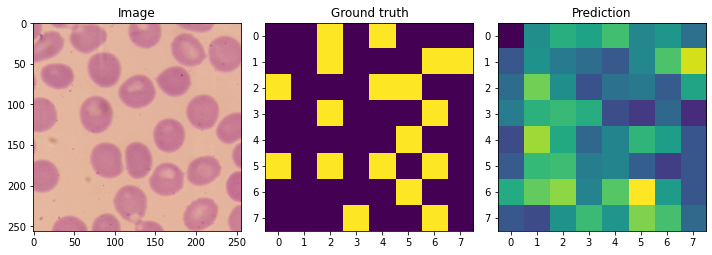

In [89]:
# Test generator pipeline

#model.load_weights('weights/training_do70_2_0.21443991.h5') # best weights, comment to start with YOLO weights

# batch
img, detector_mask, matching_true_boxes, class_one_hot, true_boxes = next(train_gen)

# y
matching_true_boxes = matching_true_boxes[0,...]
detector_mask = detector_mask[0,...]
class_one_hot = class_one_hot[0,...]
y = K.concatenate((matching_true_boxes[...,0:4], detector_mask, class_one_hot), axis = -1)

# y_hat
y_hat = model.predict_on_batch(img)[0,...]

# img
img = img[0,...]

# display prediction (Yolo Confidence value)
plt.figure(figsize=(2,2))
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 10))
ax1.imshow(img)
ax1.set_title('Image')

ax2.matshow((K.sum(y[:,:,:,4], axis=2))) # YOLO Confidence value
ax2.set_title('Ground truth')
ax2.xaxis.set_ticks_position('bottom')

ax3.matshow(K.sum(y_hat[:,:,:,4], axis=2)) # YOLO Confidence value
ax3.set_title('Prediction')
ax3.xaxis.set_ticks_position('bottom')

f.tight_layout()

# 4. Train

## 4.1. Loss function

In [90]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate IOU between box1 and box2

    Parameters
    ----------
    - x, y : box center coords
    - w : box width
    - h : box height
    
    Returns
    -------
    - IOU
    '''   
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [91]:
# loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred, info=False):
    '''
    Calculate YOLO V2 loss from prediction (y_pred) and ground truth tensors (detector_mask,
    matching_true_boxes, class_one_hot, true_boxes_grid,)

    Parameters
    ----------
    - detector_mask : tensor, shape (batch, size, GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - class_one_hot : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, class_count)
        One hot representation of bounding box label
    - true_boxes_grid : annotations : tensor (shape : batch_size, max annot, 5)
        true_boxes_grid format : x, y, w, h, c (coords unit : grid cell)
    - y_pred : prediction from model. tensor (shape : batch_size, GRID_W, GRID_H, anchors count, (5 + labels count)
    - info : boolean. True to get some infox about loss value
    
    Returns
    -------
    - loss : scalar
    - sub_loss : sub loss list : coords loss, class loss and conf loss : scalar
    '''
    
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  
    
#     # 'triple' mask
#     true_box_conf_IOU = ious * detector_mask
#     conf_mask = noobj_mask * LAMBDA_NOOBJECT
#     conf_mask = conf_mask + detector_mask * LAMBDA_OBJECT
#     nb_conf_box  = K.sum(tf.to_float(conf_mask  > 0.0))
#     conf_loss = K.sum(K.square(true_box_conf_IOU - pred_conf) * conf_mask)  / (nb_conf_box  + 1e-6) 
    
#     # total loss
#     loss = conf_loss /2. + class_loss + coord_loss /2.
#     sub_loss = [conf_loss /2., class_loss, coord_loss /2.]

    if info:
        print('conf_loss   : {:.4f}'.format(conf_loss))
        print('class_loss  : {:.4f}'.format(class_loss))
        print('coord_loss  : {:.4f}'.format(coord_loss))
        print('    xy_loss : {:.4f}'.format(xy_loss))
        print('    wh_loss : {:.4f}'.format(wh_loss))
        print('--------------------')
        print('total loss  : {:.4f}'.format(loss))
        
        # display masks for each anchors
        for i in range(len(anchors)):
            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
            f.tight_layout()
            f.suptitle('MASKS FOR ANCHOR {} :'.format(anchors[i,...]))
            
            ax1.matshow((K.sum(detector_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax1.set_title('detector_mask, count : {}'.format(K.sum(tf.cast(detector_mask[0,:,:,i]  > 0., tf.int32))))
            ax1.xaxis.set_ticks_position('bottom')
            
            ax2.matshow((K.sum(no_object_detection[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax2.set_title('no_object_detection mask')
            ax2.xaxis.set_ticks_position('bottom')
            
            ax3.matshow((K.sum(noobj_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax3.set_title('noobj_mask')
            ax3.xaxis.set_ticks_position('bottom')
              
    return loss, sub_loss

conf_loss   : 0.7260
class_loss  : 1.3027
coord_loss  : 0.7034
    xy_loss : 0.1462
    wh_loss : 0.5572
--------------------
total loss  : 2.7321


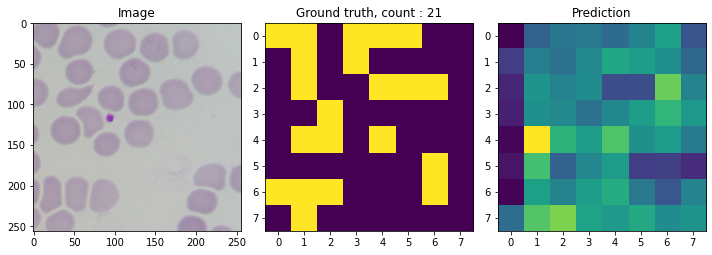

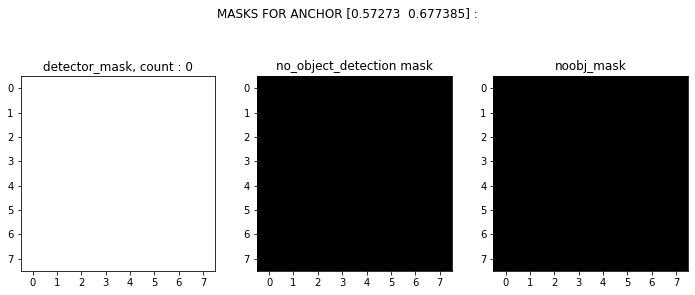

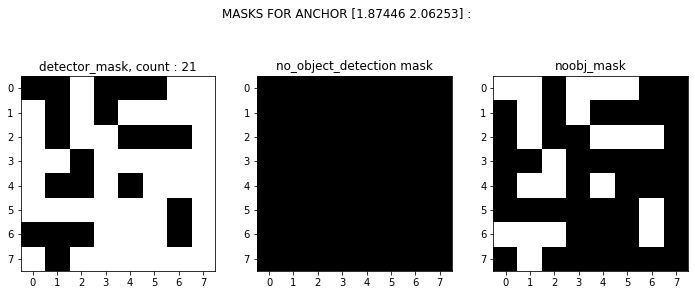

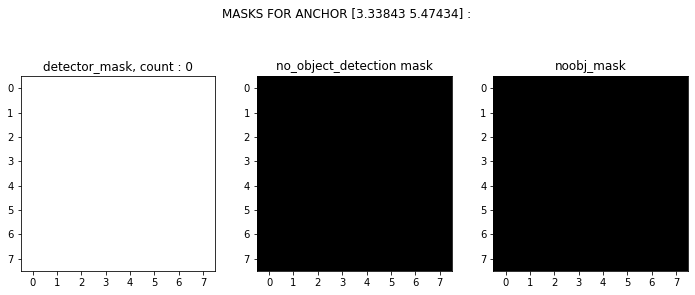

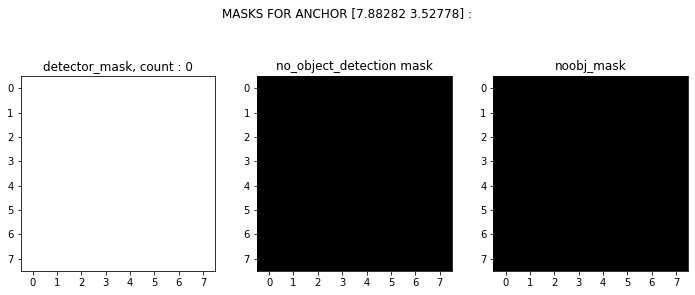

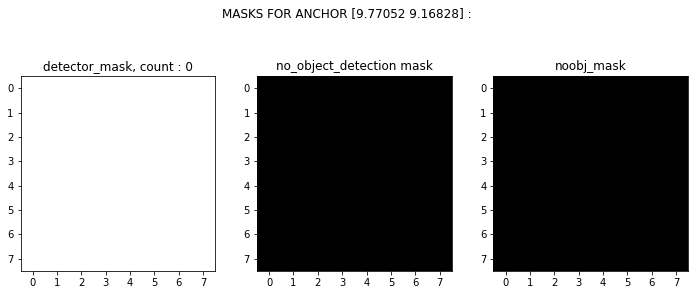

In [92]:
# test loss

# get batch
img, detector_mask, matching_true_boxes, class_one_hot, true_boxe_grid = next(train_gen)

# first image in batch
img = img[0:1]
detector_mask = detector_mask[0:1]
matching_true_boxes = matching_true_boxes[0:1]
class_one_hot = class_one_hot[0:1]
true_boxe_grid = true_boxe_grid[0:1]

# predict
y_pred = model.predict_on_batch(img)

# plot img, ground truth and prediction
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
ax1.imshow(img[0,...])
ax1.set_title('Image')
ax2.matshow(K.sum(detector_mask[0,:,:,:,0], axis=2)) # YOLO Confidence value
ax2.set_title('Ground truth, count : {}'.format(K.sum(tf.cast(detector_mask  > 0., tf.int32))))
ax2.xaxis.set_ticks_position('bottom')
ax3.matshow(K.sum(y_pred[0,:,:,:,4], axis=2)) # YOLO Confidence value
ax3.set_title('Prediction')
ax3.xaxis.set_ticks_position('bottom')
f.tight_layout()

# loss info
loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxe_grid, y_pred, info = True)

## 4.2. Training

In [93]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=True):
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
    return loss, sub_loss, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join('../data/weights/', name + '*'))
#     for file in files:
#         os.remove(file)
    # create new weights file
    name = name + '_' + str(val_loss_avg) + '.h5'
    path_name = os.path.join('../data/weights/', name)
    model.save_weights(path_name)

# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [94]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join('../logs/', train_name), flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
            loss, _, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, sub_loss, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=False)
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(sub_loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
        
        print(' loss = {:.4f}, val_loss = {:.4f} (conf={:.4f}, class={:.4f}, coords={:.4f})'.format(
            loss_avg, val_loss_avg, sub_loss_avg[0], sub_loss_avg[1], sub_loss_avg[2]))
        
    return [train_loss_history, val_loss_history]

In [ ]:
results = train(EPOCHS, model, train_gen, val_gen, 10, 2, 'yolo2')

plt.plot(results[0])
plt.plot(results[1])

Epoch 0 :
---------- | -- loss = 1.8303, val_loss = 1.9753 (conf=0.4729, class=1.0640, coords=0.4383)
Epoch 1 :
---------- | -- loss = 1.3633, val_loss = 1.5265 (conf=0.3705, class=0.8402, coords=0.3159)
Epoch 2 :
---------- | -- loss = 1.0950, val_loss = 1.3342 (conf=0.3483, class=0.7020, coords=0.2839)
Epoch 3 :
---------- | -- loss = 0.9710, val_loss = 1.0642 (conf=0.3031, class=0.5042, coords=0.2570)
Epoch 4 :
---------- | -- loss = 0.8859, val_loss = 0.9878 (conf=0.3112, class=0.4330, coords=0.2435)
Epoch 5 :
---------- | -- loss = 0.8002, val_loss = 0.8934 (conf=0.3100, class=0.3437, coords=0.2397)
Epoch 6 :
---------- | -- loss = 0.7088, val_loss = 0.8422 (conf=0.2953, class=0.3112, coords=0.2357)
Epoch 7 :
---------- | -- loss = 0.6794, val_loss = 0.7513 (conf=0.2797, class=0.2497, coords=0.2219)
Epoch 8 :
---------- | -- loss = 0.6870, val_loss = 0.6469 (conf=0.2754, class=0.1909, coords=0.1806)
Epoch 9 :
---------- | -- loss = 0.6085, val_loss = 0.6419 (conf=0.2727, class=0.1

# 5. Results

In [ ]:
def display_yolo(file, model, score_threshold, iou_threshold):
    '''
    Display predictions from YOLO model.

    Parameters
    ----------
    - file : string list : list of images path.
    - model : YOLO model.
    - score_threshold : threshold used for filtering predicted bounding boxes.
    - iou_threshold : threshold used for non max suppression.
    '''
    # load image
    image = cv2.imread(file)

    input_image = image[:,:,::-1]
    input_image = image / 255.
    input_image = np.expand_dims(input_image, 0)

    # prediction
    y_pred = model.predict_on_batch(input_image)

    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = (pred_xy + coords)
    pred_xy = pred_xy / dims
    pred_wh = K.exp(y_pred[:,:,:,:,2:4])
    pred_wh = (pred_wh * anchors)
    pred_wh = pred_wh / dims
    # pred_confidence
    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  
    # pred_class
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])

    # Reshape
    pred_xy = pred_xy[0,...]
    pred_wh = pred_wh[0,...]
    box_conf = box_conf[0,...]
    box_class_prob = box_class_prob[0,...]

    # Convert box coords from x,y,w,h to x1,y1,x2,y2
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    # Filter boxes
    box_scores = box_conf * box_class_prob
    box_classes = K.argmax(box_scores, axis=-1) # best score index
    box_class_scores = K.max(box_scores, axis=-1) # best score
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # Scale box to image shape
    boxes = boxes * IMAGE_H

    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    
    # Draw image
    plt.figure(figsize=(2,2))
    f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
    ax1.imshow(image[:,:,::-1])
    count_detected = boxes.shape[0]
    ax1.set_title('Detected objects count : {}'.format(count_detected))
    for i in range(count_detected):
        box = boxes[i,...]
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        classe = classes[i].numpy()
        if classe == 0:
            color = (0, 1, 0)
        else:
            color = (1, 0, 0)
        rect = patches.Rectangle((x.numpy(), y.numpy()), w.numpy(), h.numpy(), linewidth = 3, edgecolor=color,facecolor='none')
        ax1.add_patch(rect)

In [ ]:
 for img_name_test in imgs_name_test[0:50]:
    x_files =  glob.glob(img_name_test)

    score = SCORE_THRESHOLD
    iou_threshold = IOU_THRESHOLD

    for file in x_files[::3]:
        display_yolo(file, model, score, iou_threshold)
    
    img = cv2.imread(img_name_test)
    list_bbxs = dict_bbxs[img_name_test]
    img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
    plt.imshow(img_with_box)
    